In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

In [3]:
df=pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df=df.rename(columns={'aggregated_value':'count', 'country':'Mention_country', 'affiliation_country':'Aff_country'})

df=df[df['year'].isin(np.arange(2003, 2019, 1))]
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP','MULT']
df=df[~df['subjarea'].isin(physical_sciences)]

In [22]:
def find_cat(subject):  
    social_sciences=['PSYC', 'SOCI', 'DECI', 'ARTS', 'ECON', 'BUSI']
    health_sciences=['MEDI', 'NURS', 'DENT', 'HEAL', 'VETE']
    physical_sciences=['CHEM', 'EART', 'ENER', 'CENG',  'ENVI','MATE']
    life_sciences=['PHAR', 'NEUR', 'AGRI', 'IMMU', 'BIOC']
    if subject in social_sciences:
        return 'Social sciences'
    elif  subject in health_sciences:
        return 'Health sciences'
    elif subject in physical_sciences:
        return 'Physical sciences'
    elif subject in life_sciences:
        return 'Life sciences'
    else:
        return subject

In [8]:
df['cat']=df['subjarea'].apply(find_cat)
df['year_arabspring']=df['year'].apply(lambda x: 'before' if x>=2003 and x<=2010 else 'after' )
df['is_internal_attention']=df['Mention_country']==df['Aff_country']

result_df=df.groupby(['cat','Mention_country', 'year_arabspring', 'is_internal_attention'])['count'].sum().reset_index()

total_df=result_df.groupby(['Mention_country','year_arabspring'])['count'].sum().reset_index().rename(columns={'count':'total'})

result_df=result_df.merge(total_df, on=['Mention_country','year_arabspring'])
result_df['Share']=result_df['count']/result_df['total']

In [27]:
# Group by `cat` and `Mention_country` and compute the ratio of `count` for `is_internal_attention=False` to the total `count` for each group
df_grouped = (
    df.groupby(["cat", "Mention_country", "year_arabspring"])
    .apply(lambda x: x.loc[x["is_internal_attention"] == False, "count"].sum() / x["count"].sum())
    .reset_index(name="is_internal_attention_ratio")
)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_40764\3944084289.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["is_internal_attention"] == False, "count"].sum() / x["count"].sum())


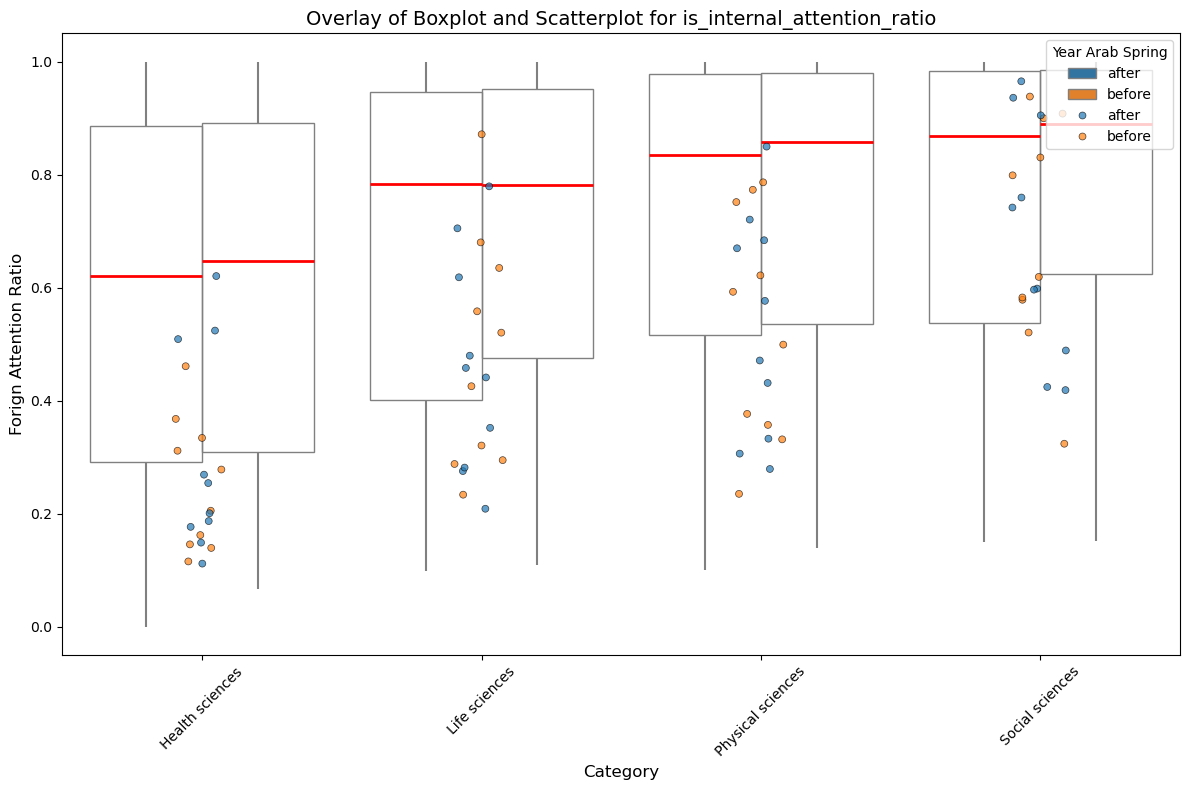

In [54]:
# Filter out undefined categories
df_filtered = df_grouped.query('cat != "undefined"')

# Create a figure
plt.figure(figsize=(12, 8))

# Plot the boxplot
sns.boxplot(
    data=df_filtered,
    x='cat',
    y='is_internal_attention_ratio',
    hue='year_arabspring',
    dodge=True,  # Avoid overlapping hues in boxplots
    showcaps=False,  # Optionally hide the caps
    boxprops={'facecolor': 'None', 'edgecolor': 'gray'},  # Transparent fill for boxes
    whiskerprops={'linewidth': 1.5, 'color': 'gray'},  # Styling whiskers
    medianprops={'linewidth': 2, 'color': 'red'}  # Styling median lines
)

# Plot the scatterplot on top of the boxplot
df_scatter = df_filtered[df_filtered['Mention_country'].isin(abbr)]
sns.stripplot(
    data=df_scatter,
    x='cat',
    y='is_internal_attention_ratio',
    hue='year_arabspring',
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5,
    marker='o'
)

# Adjust the layout
plt.title('Overlay of Boxplot and Scatterplot for is_internal_attention_ratio', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Forign Attention Ratio', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the legend
plt.legend(loc='upper right', title='Year Arab Spring')

# Display the plot
plt.show()


In [50]:
# Pivot the table to bring "before" and "after" as columns
pivoted_df = df_filtered.pivot(index=["cat", "Mention_country"], columns="year_arabspring", values="is_internal_attention_ratio").reset_index()

# Rename columns for clarity
pivoted_df.columns.name = None  # Remove the multiindex column name
pivoted_df.rename(columns={"after": "after_ratio", "before": "before_ratio"}, inplace=True)

pivoted_df['difference_ratio']=pivoted_df['after_ratio']-pivoted_df['before_ratio']

In [58]:
pivoted_df

,cat,Mention_country,after_ratio,before_ratio,difference_ratio
0,Health sciences,Cape Verde,1.000000,1.000000,0.000000
1,Health sciences,Curacao,1.000000,1.000000,0.000000
2,Health sciences,East Timor,1.000000,1.000000,0.000000
3,Health sciences,Falkland Islands,1.000000,1.000000,0.000000
4,Health sciences,Ivory Coast,1.000000,1.000000,0.000000
...,...,...,...,...,...
1052,Social sciences,yem,0.904863,0.907940,-0.003077
1053,Social sciences,yug,1.000000,0.990895,0.009105
1054,Social sciences,zaf,0.250125,0.337319,-0.087194
1055,Social sciences,zmb,0.806998,0.810726,-0.003728


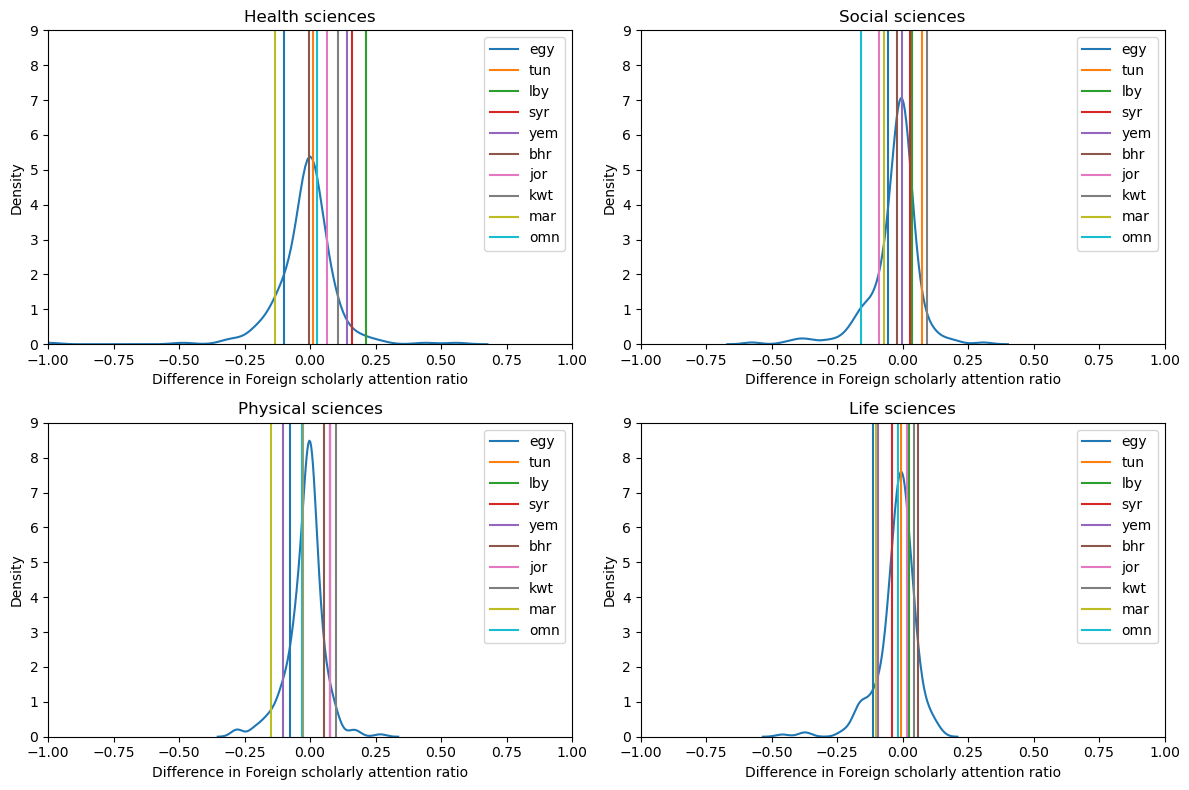

In [87]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
ax=ax.flat
for i, category in enumerate(['Health sciences', 'Social sciences', 'Physical sciences', 'Life sciences']):
    subset = pivoted_df.query(f'cat == "{category}"')
    ax[i].set_title(category)
    sns.kdeplot(subset, x='difference_ratio', ax=ax[i])
    for k, c in enumerate(abbr):
        ax[i].axvline(subset[subset['Mention_country']==c].iloc[0]['difference_ratio'], color=f'C{k}', label=c)
    ax[i].set_xlim(-1,1)
    ax[i].set_ylim(0,9)
    ax[i].legend()
    ax[i].set_xlabel('Difference in Foreign scholarly attention ratio')

plt.tight_layout()

In [75]:
subset[subset['Mention_country']=='yem'].iloc[0]['difference_ratio']

0.14119902588837852

In [72]:
subset[subset['Mention_country']=={c}]

,cat,Mention_country,after_ratio,before_ratio,difference_ratio


,cat,Mention_country,after_ratio,before_ratio,difference_ratio
83,Health sciences,egy,0.176573,0.278019,-0.101446


In [56]:
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}


['egy', 'tun', 'lby', 'syr', 'yem', 'bhr', 'jor', 'kwt', 'mar', 'omn']